# Imports and Settings

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm
from laplace import Laplace
from utils.dataset import get_dataset
from utils.models import get_mlp
from utils.pytorch_learning import fit_map

In [2]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,
        "iterations": 20000,
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1
}

In [3]:
torch.manual_seed(params["seed"])

In [4]:
dataset = get_dataset("synthetic2")
train_dataset, train_test_dataset, test_dataset = dataset.get_split()

Number of samples:  400
Input dimension:  1
Label dimension:  1
Labels mean value:  0
Labels standard deviation:  1


In [5]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
train_test_loader = DataLoader(train_test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# MAP Learning

In [6]:
f = get_mlp(
    train_dataset.inputs.shape[1],
    train_dataset.targets.shape[1],
    params["bnn_structure"],
    params["activation"],
    device=params["device"],
    dtype=params["dtype"],
)

# Define optimizer and compile model
opt = torch.optim.Adam(f.parameters(), lr=params["MAP_lr"])
criterion = torch.nn.MSELoss()

# Set the number of training samples to generate
# Train the model
start = timer()

loss = fit_map(
    f,
    train_loader,
    opt,
    criterion=torch.nn.MSELoss(),
    use_tqdm=True,
    return_loss=True,
    iterations=12000,
    device=params["device"],
)
end = timer()

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


Training : 100%|██████████| 12000/12000 [00:27<00:00, 434.10 iteration/s]


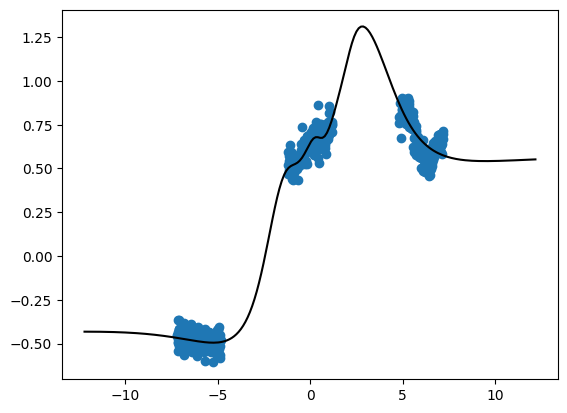

In [7]:
plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")



sort = np.argsort(test_dataset.inputs.flatten())


plt.plot(
    test_dataset.inputs.flatten()[sort],
    f(torch.tensor(test_dataset.inputs)).detach().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.show()

# Full LLA

In [8]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "full"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

prior_std = np.sqrt(1 / np.exp(log_prior.detach().numpy())).item()
log_variance = 2*log_sigma.detach().numpy().item()

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


In [9]:
print("Optimal GP prior std: ", prior_std)
print("Optimal GP likelihoog log variance: ", log_variance)

Optimal GP prior std:  2.156211072302787
Optimal GP likelihoog log variance:  -5.5347821004082105


In [10]:
def distribution_plot(model_predictive, log_variance, name = None):
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(16,7))
    mean, var = model_predictive(torch.tensor(test_dataset.inputs, dtype = params["dtype"]))
    mean = mean.detach().numpy()
    var = var.detach().numpy() + np.exp(log_variance)
    std = np.sqrt(var).flatten()
    sort = np.argsort(test_dataset.inputs.flatten())

    fig = plt.scatter(train_dataset.inputs, 
                    train_dataset.targets, 
                    color = "black")

    plt.plot(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort],
        color="cornflowerblue",
    )
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort] - 2 * std[sort],
        mean.flatten()[sort] + 2 * std[sort],
        alpha=0.2,
        color="cornflowerblue",
    )

    #plt.axis('off')
    plt.ylim(-2.5 ,5)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig("./plots/" + name+ ".pdf", format="pdf", bbox_inches='tight')
    plt.show()


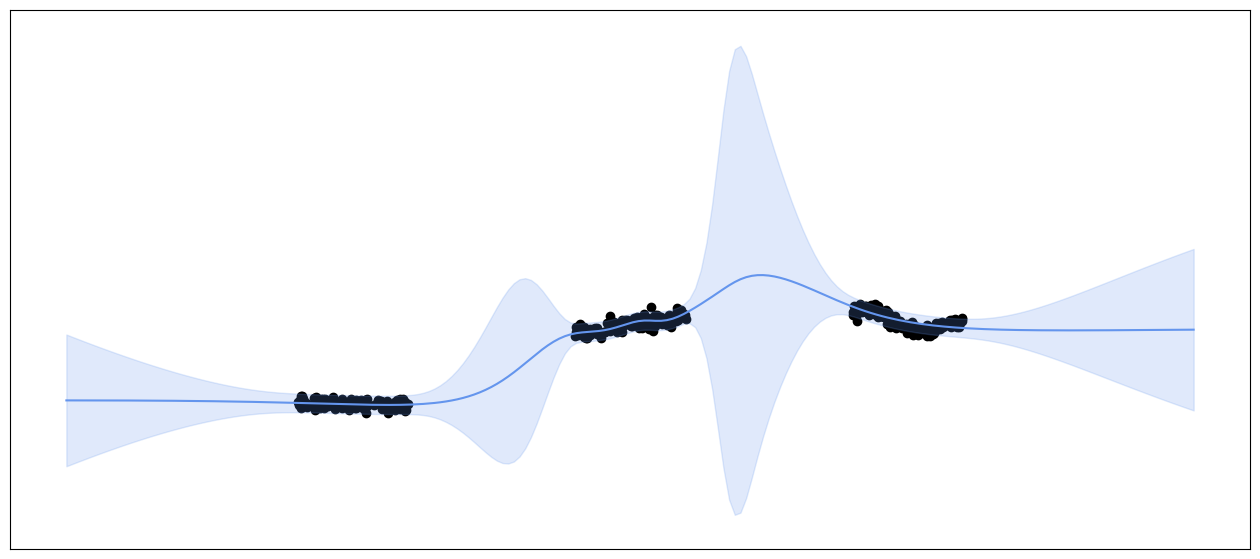

In [11]:
distribution_plot(la._glm_predictive_distribution, log_variance, "LLA")

# Quadratic Laplace

In [12]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "quad"
quad_la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
quad_la.fit(train_loader)

log_prior_quad, log_sigma_quad = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior_quad, log_sigma_quad], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -quad_la.log_marginal_likelihood(log_prior_quad.exp(), log_sigma_quad.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

prior_std_quad = np.sqrt(1 / np.exp(log_prior_quad.detach().numpy())).item()
log_variance_quad = 2*log_sigma_quad.detach().numpy().item()

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


In [13]:
print("Optimal GP prior std: ", prior_std_quad)
print("Optimal GP likelihoog log variance: ", log_variance_quad)

Optimal GP prior std:  2.1557535783947004
Optimal GP likelihoog log variance:  -5.534764506201917


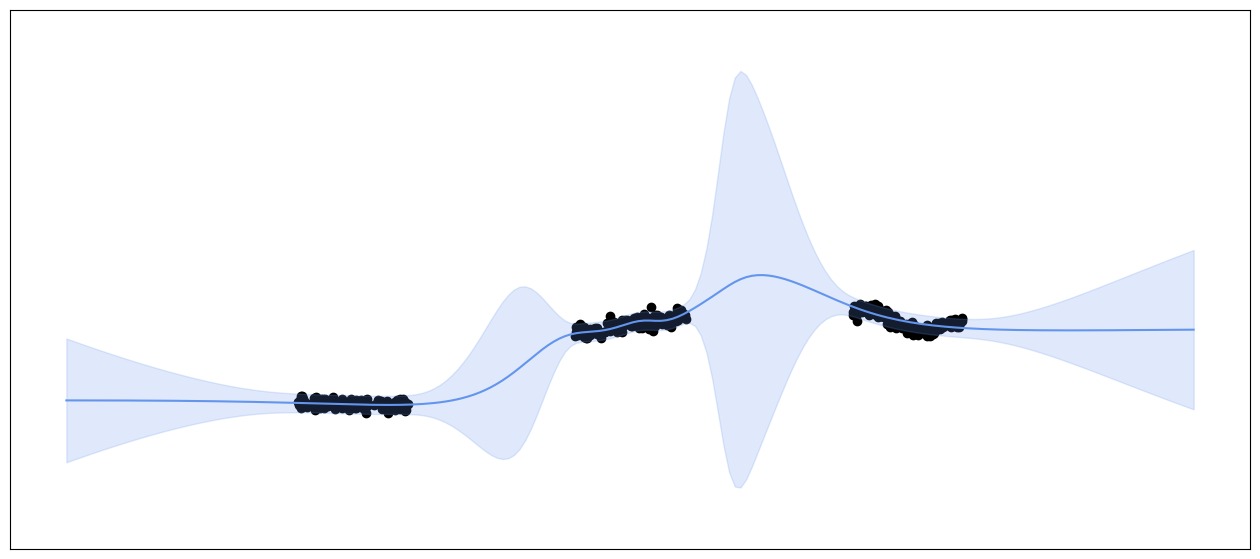

In [14]:
distribution_plot(quad_la._glm_predictive_distribution, log_variance_quad, "Quadratic")

# Comparación

In [15]:
def various_dist_plot(model1_predictive, model2_predictive, log_var1, log_var2, label1, label2, name=None):
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(16, 7))

    # Model 1
    mean1, var1 = model1_predictive(torch.tensor(test_dataset.inputs, dtype=params["dtype"]))
    mean1 = mean1.detach().numpy()
    var1 = var1.detach().numpy() + np.exp(log_var1)
    std1 = np.sqrt(var1).flatten()

    # Model 2
    mean2, var2 = model2_predictive(torch.tensor(test_dataset.inputs, dtype=params["dtype"]))
    mean2 = mean2.detach().numpy()
    var2 = var2.detach().numpy() + np.exp(log_var2)
    std2 = np.sqrt(var2).flatten()

    #print((mean1==mean2).all()) Sale true, tal y como se esperaba

    sort = np.argsort(test_dataset.inputs.flatten())

    fig = plt.scatter(train_dataset.inputs, 
                      train_dataset.targets, 
                      color="black",
                      label="Training data")

    # Plot the shared mean line (since mean1 == mean2)
    plt.plot(
        test_dataset.inputs.flatten()[sort],
        mean1.flatten()[sort],
        color="black",
        label="Predictive mean",
    )

    # Uncertainty for model 1
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean1.flatten()[sort] - 2 * std1[sort],
        mean1.flatten()[sort] + 2 * std1[sort],
        alpha=0.2,
        color="cornflowerblue",
        label=label1,
    )

    # Uncertainty for model 2
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean2.flatten()[sort] - 2 * std2[sort],
        mean2.flatten()[sort] + 2 * std2[sort],
        alpha=0.2,
        color="salmon",
        label=label2,
    )

    plt.ylim(-2.5, 5)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    plt.legend(loc="upper left")

    if name is not None:
        plt.savefig("./plots/" + name + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()


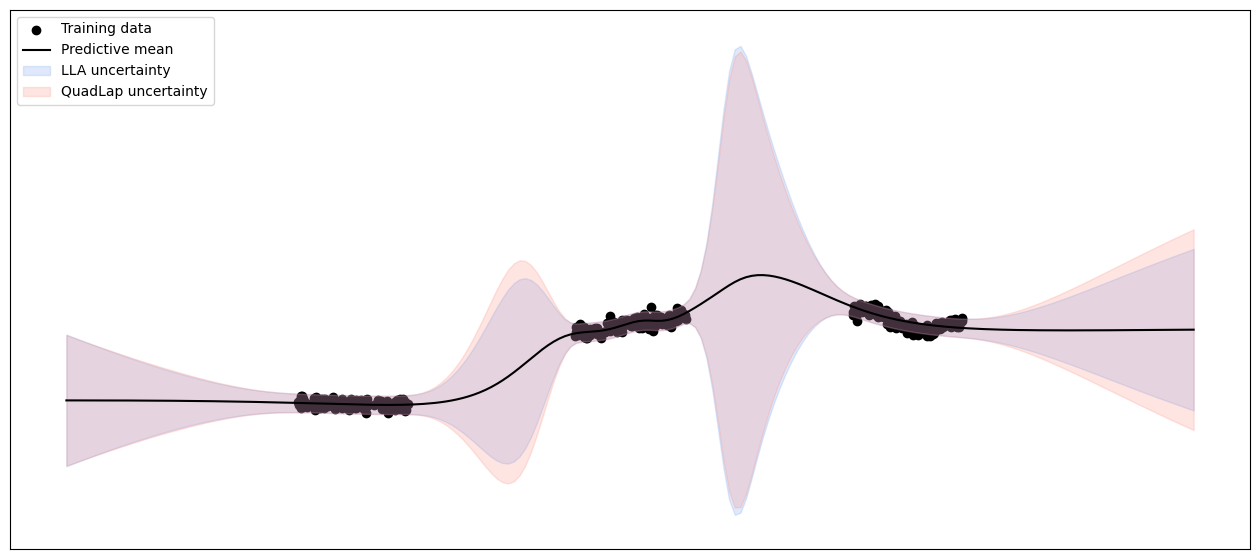

In [16]:
various_dist_plot(la._glm_predictive_distribution, quad_la._glm_predictive_distribution, log_variance, log_variance_quad, "LLA uncertainty", "QuadLap uncertainty", "LLA vs QuadLap")                

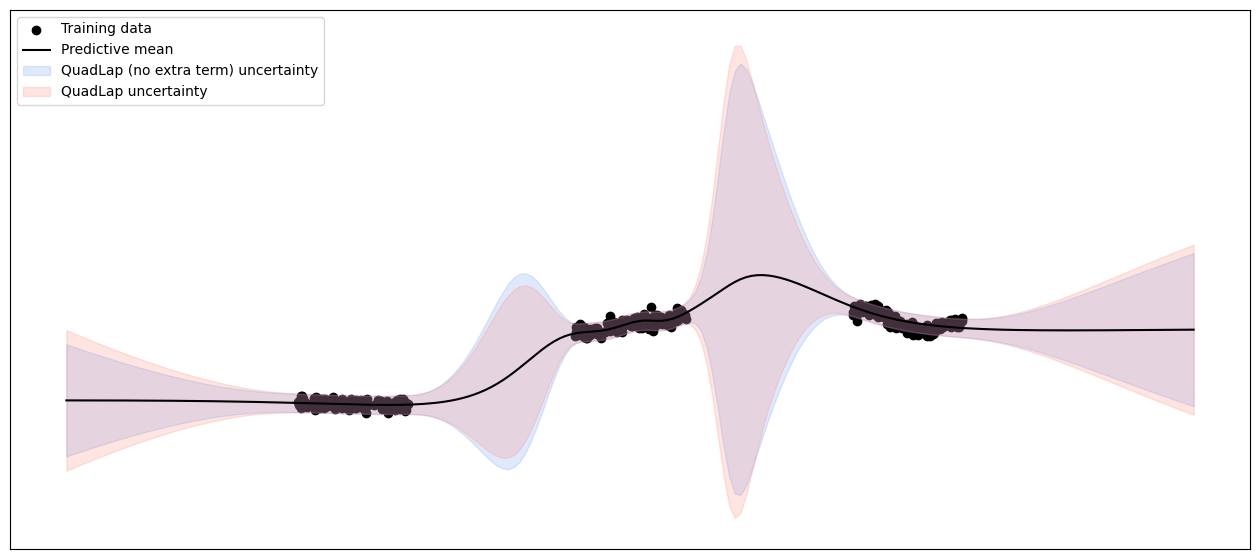

In [17]:
various_dist_plot(quad_la._glm_predictive_distribution_noextra, quad_la._glm_predictive_distribution, log_variance_quad, log_variance_quad, "QuadLap (no extra term) uncertainty", "QuadLap uncertainty", "QuadLap no extra term vs QuadLap")                

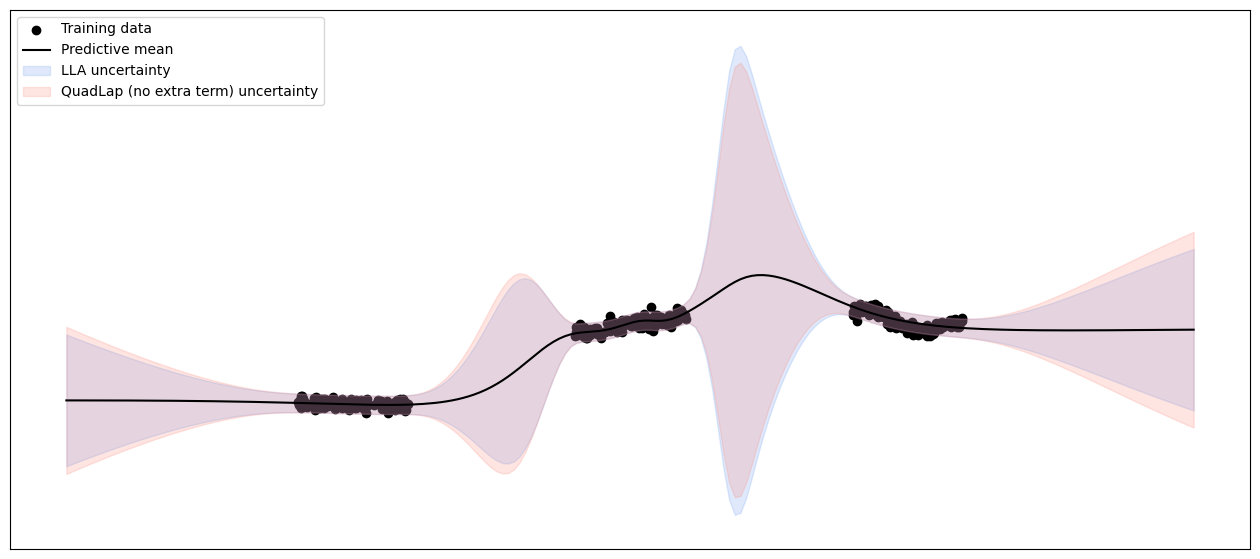

In [18]:
various_dist_plot(la._glm_predictive_distribution, quad_la._glm_predictive_distribution_noextra, log_variance, log_variance_quad, "LLA uncertainty", "QuadLap (no extra term) uncertainty", "LLA vs QuadLap no extra term")                